# Part-of-speech tagging

#### Import libraries

In [13]:
from datetime import datetime
from functools import reduce
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from tensorflow import keras
from tensorflow.keras import layers
from typing import List, Callable, Dict
import urllib.request  #  download files
import zipfile  #  unzip files

#### Define constant variables

In [14]:
train_path = './Dataset/train/'
val_path = './Dataset/val/'
test_path = './Dataset/test/'
dataset_folder = os.path.join(os.getcwd(), "OriginalDataset")
original_path = dataset_folder +'/dependency_treebank/'

embedding_dimension = 50


## Data pipeline

#### Download dataset

In [15]:
def download_dataset():
    dataset_folder = os.path.join(os.getcwd(), "OriginalDataset")

    if not os.path.exists(dataset_folder):
        os.makedirs(dataset_folder)

    url = 'https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip'

    dataset_path = os.path.join(dataset_folder, "dependency_treebank.zip")

    if not os.path.exists(dataset_path):
        urllib.request.urlretrieve(url, dataset_path)
        print("Successful download")

    with zipfile.ZipFile(dataset_path,"r") as zip_ref:
        zip_ref.extractall(dataset_folder)
    print("Successful extraction")

In [16]:
# Uncomment to download dataset
download_dataset()

Successful extraction


#### Split dataset

In [17]:
def split_dataset(train_path, val_path, test_path, original_path):
    if not os.path.exists(train_path):
        print("making directory")
        os.makedirs(train_path)
    if not os.path.exists(val_path):
        os.makedirs(val_path)
    if not os.path.exists(test_path):
        os.makedirs(test_path)

    original_dataset = os.listdir(original_path)
    
    original_dataset.sort()
    org_train = original_dataset[0:100]
    org_val = original_dataset[100:150]
    org_test = original_dataset[150:]

    for f in org_train:
        os.rename(original_path+f, train_path+f)
    for f in org_val:
        os.rename(original_path+f, val_path+f)
    for f in org_test:
        os.rename(original_path+f, test_path+f)
    print("Successful spilt")
        

In [18]:
# Uncomment the following line to split the dataset
split_dataset(train_path, val_path, test_path, original_path)


Successful spilt


#### Create dataframe

In [19]:
def create_dataframe(dataset_path: str):
    dataframe_rows = []
    documents = os.listdir(dataset_path)
    for document in documents:
        path = os.path.join(dataset_path, document)
        with open(path, 'r') as f:
            a = [[x for x in ln.split()] for ln in f]
        #---------------For splitting on sentence-------------------#
        sentence = []
        sentence_tag = []
        for x in a:
            if x!=[]:
                sentence.append(x[0])
                sentence_tag.append(x[1])
            else:
                dataframe_row = {
                    "text": sentence,
                    "POS": sentence_tag
                }
                sentence = []
                sentence_tag = []
                dataframe_rows.append(dataframe_row)
        #----------------------------------------------------------#
        #------------------To split on document--------------------#
        """
        a2 = [x for x in a if x != []] # OBS! Removing all empty lines in file so we can make an array
        arr = np.array(a2)
        text = list(arr[:, 0])
        tagg = list(arr[:, 1])
        #POStuple =  [tagg[x] for x in range(len(text))] #[(text[x], tagg[x]) for x in range(len(text))]
        document_id = int(document[4:8])
        dataframe_row = {
            "document_id": document_id,
            "text": text,
            "POS": tagg
        }
        dataframe_rows.append(dataframe_row)"""
        #----------------------------------------------------------#
    # transform the list of rows in a proper dataframe
    df = pd.DataFrame(dataframe_rows)
    df = df[["text", "POS"]]

    return df

In [20]:
df_train = create_dataframe(train_path)
df_val = create_dataframe(val_path)
df_test = create_dataframe(test_path)

## Clean and transform data

#### Clean text in data frame
We remove uncommon symbols and special characters and make all text to lower case.

In [ ]:
REPLACE_BY_SPACE_RE = re.compile("[/(){}\[\]\|@,;]")
GOOD_SYMBOLS_RE = re.compile("[^0-9a-z #+_$]")

def lower(text: str) -> str:
    """
    Transforms given text to lower case.
    Example:
    Input: 'I really like New York city'
    Output: 'i really like new your city'
    """

    return text.lower()

def remove_special_characters(text: str) -> str:
    """
    Replaces special characters, such as paranthesis,
    with spacing character
    """

    return REPLACE_BY_SPACE_RE.sub('', text)

def filter_out_uncommon_symbols(text: str) -> str:
    """
    Removes any special character that is not in the
    good symbols list (check regular expression)
    """

    return GOOD_SYMBOLS_RE.sub('', text)

PREPROCESSING_PIPELINE = [
                          lower,
                          remove_special_characters,
                          filter_out_uncommon_symbols,
                          ]

def text_prepare(text,
                 filter_methods: List[Callable[[str], str]] = None) -> str:
    """
    Applies a list of pre-processing functions in sequence (reduce).
    Note that the order is important here!
    """

    filter_methods = filter_methods if filter_methods is not None else PREPROCESSING_PIPELINE

    new_row = [reduce(lambda txt, f: f(txt), filter_methods, x) for x in text]
    return [x for x in new_row if x!='']


# Replace each sentence with its pre-processed version
df_train['text'] = df_train['text'].apply(lambda txt: text_prepare(txt))
df_train['POS'] = df_train['POS'].apply(lambda txt: text_prepare(txt))
df_val['text'] = df_val['text'].apply(lambda txt: text_prepare(txt))
df_val['POS'] = df_val['POS'].apply(lambda txt: text_prepare(txt))
df_test['text'] = df_test['text'].apply(lambda txt: text_prepare(txt))
df_test['POS'] = df_test['POS'].apply(lambda txt: text_prepare(txt))

### Embed the words using GloVe embedding

#### Load glove model

In [ ]:
import gensim
import gensim.downloader as gloader

def load_embedding_model(embedding_dimension: int = 50) -> gensim.models.keyedvectors.KeyedVectors:
    download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
    # Check download
    try:
        emb_model = gloader.load(download_path)
    except ValueError as e:
        print("Invalid embedding model name! Check the embedding dimension:")
        print("Word2Vec: 300")
        print("Glove: 50, 100, 200, 300")
        raise e

    return emb_model

In [ ]:
embedding_model = load_embedding_model(embedding_dimension)

#### Tokenize data
We tokenize the data by using the keras tokenizer

In [ ]:
def make_tokenizer(*vocabulary):
    # We do not want to remove the $ since this is part of some tags in POS tagging,
    # so we define the filter to not include $
    tokenizer = Tokenizer(filters='!"#%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')

    for v in vocabulary:
        v2 = sum(v.to_numpy().flatten(), [])
        tokenizer.fit_on_texts(v2)
    return tokenizer 


In [ ]:
# Create tokenizer for all the words in the vocabulary
# Since in this case, where we already have all the documents, 
# and we can make a word index for every word in the vocabulary.
word_tokenizer = make_tokenizer(df_train["text"], df_val["text"], df_test["text"])

# Create tokenizer for all the tags
tag_tokenizer = make_tokenizer(df_train["POS"])

In [ ]:
# Get size of word vocabulary and tag vocabulary
VOCABULARY_SIZE = len(word_tokenizer.word_index) + 1
TAG_VOCABULARY_SIZE = len(tag_tokenizer.word_index) + 1

#### Encode text (x) and tags (y)
We use the tokenizer to encode the text to the words their corresponding indices

In [ ]:
# Encode train data
x_encoded_train = word_tokenizer.texts_to_sequences(df_train["text"])
y_encoded_train = tag_tokenizer.texts_to_sequences(df_train["POS"])

# Encode validation data
x_encoded_val = word_tokenizer.texts_to_sequences(df_val["text"])
y_encoded_val = tag_tokenizer.texts_to_sequences(df_val["POS"])

# Encode test data
x_encoded_test = word_tokenizer.texts_to_sequences(df_test["text"])
y_encoded_test = tag_tokenizer.texts_to_sequences(df_test["POS"])

#### Pad encoded sequences
The sequences needs to have the same length when they are sendt into the model. We therefore post-pad the sequences with zeros. 

In [ ]:
def find_max_length(seqs):
    """
    Funciton for finding the maximum length of a sequence.
    This is used for padding the sequences
    """
    max_len = 0
    for seq in seqs:
        if len(seq) > max_len:
            max_len = len(seq)
    return max_len

# Get max sequence length
MAX_LENGTH = find_max_length(x_encoded_train)

In [ ]:
def pad_idx_seqs(idx_seqs, max_seq_len):
    # Keras provides a convenient padding function; 
    padded_idxs = pad_sequences(sequences=idx_seqs, maxlen=max_seq_len, padding="post")
    return padded_idxs

In [ ]:
# Pad train data
x_padded_train = pad_idx_seqs(x_encoded_train, MAX_LENGTH)
y_padded_train = pad_idx_seqs(y_encoded_train, MAX_LENGTH)

# Pad validation data
x_padded_val = pad_idx_seqs(x_encoded_val, MAX_LENGTH)
y_padded_val = pad_idx_seqs(y_encoded_val, MAX_LENGTH)

# Pad test data
x_padded_test = pad_idx_seqs(x_encoded_test, MAX_LENGTH)
y_padded_test = pad_idx_seqs(y_encoded_test, MAX_LENGTH)

#### Create embedding matrix
We use the pretrained glove model to create the embedding matrix.
If there are any OOV we create a random embedding vector. 

In [ ]:
def create_embedding_matrix(embedding_model, embedding_dimension, VOCABULARY_SIZE, word_to_idx):
    embedding_matrix = np.zeros((VOCABULARY_SIZE, embedding_dimension), dtype=np.float32)
    for word, idx in word_to_idx.items():
        try:
            embedding_vector = embedding_model[word]
        except (KeyError, TypeError):
            embedding_vector = np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension)

        embedding_matrix[idx] = embedding_vector
                                
    return embedding_matrix                             

In [ ]:
embedding_matrix = create_embedding_matrix(embedding_model, embedding_dimension, VOCABULARY_SIZE, word_tokenizer.word_index)

#### Define x and y parameters
Y parameters must be converted from array of labeled data(from 0 to nb_classes - 1 ) to one-hot vector. 
This is done with the Keras to_categorical function

In [ ]:
# Train data
x_train = x_padded_train
y_train = to_categorical(y_padded_train)

# Validation data
x_val = x_padded_val
y_val = to_categorical(y_padded_val, num_classes=TAG_VOCABULARY_SIZE)

# Test data
x_test = x_padded_test
# y_test is only used for predictions, and should therefore not be one hot encoded.
y_test = y_padded_test  

### Define functions for testing and evaluate the models

#### Define plotting functions

In [ ]:
def plot_accuracy(model_callback, model_name='baseline_model'):
    plt.plot(model_callback.history['acc'])
    plt.plot(model_callback.history['val_acc'])
    plt.title(f'{model_name} accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc="lower right")
    plt.show()
    
def plot_loss(model_callback, model_name='baseline_model'):
    plt.plot(model_callback.history['loss'])
    plt.plot(model_callback.history['val_loss'])
    plt.title(f'{model_name} loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc="lower right")
    plt.show()

#### Functions for prediction

In [ ]:
def predict(model: keras.Model, x, predicting_info):
    predictions = model.predict(x, **predicting_info)
    return predictions

#### Funcions for evaluation 

In [ ]:
def remove_padding(y_test, y_pred_int):
    # Remove the padding classifications
    all_true_tags = [tag for sent_tags in y_test for tag in sent_tags]
    all_pred_tags = [tag for sent_tags in y_pred_int for tag in sent_tags]
    
    new_true_tags = []
    new_pred_tags = []
    for i, x in enumerate(all_true_tags):
        if x!= 0:
            new_true_tags.append(x)
            new_pred_tags.append(all_pred_tags[i])

    return new_true_tags, new_pred_tags

In [ ]:
def plot_confusion_matrix(confusion_m, tagIdxList):
    # Plot the confusion matrix as a heat map
    df_cm = pd.DataFrame(confusion_m, index = tagIdxList,
                    columns = tagIdxList)
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=False)

In [ ]:
def evaluate(y_test, predictions, idx2tag):
    """
        Evaluates the model by computing accuracy, precission, recall and f1 score.
        Prints classification report
        Calculates and plots confusion_matrix
        Inputs:
            y_test: ground truth for test set
            predicitons: perdicitons calculated by the model
            idx2tag: Dicitonary of all tags and corresponding indexes. 
    """
    y_pred_int = np.argmax(predictions, axis=2)
    new_true_tags, new_pred_tags = remove_padding(y_test, y_pred_int)

    accuracy = accuracy_score(y_true=new_true_tags, y_pred=new_pred_tags)
    precision = precision_score(y_true=new_true_tags, y_pred=new_pred_tags, average='weighted', zero_division=0)
    recall = recall_score(y_true=new_true_tags, y_pred=new_pred_tags, average='weighted', zero_division=0)
    f1 = f1_score(y_true=new_true_tags, y_pred=new_pred_tags, average='weighted', zero_division=0)

    print("ACCURACY: {:.3f}".format(accuracy))
    print("PRECISION: {:.3f}".format(precision))
    print("RECALL: {:.3f}".format(recall))
    print("F1: {:.3f}".format(f1))
    
    tags = list(idx2tag.values())
    tagIdxList = list(idx2tag.keys())
    report = classification_report(new_true_tags, new_pred_tags, labels=tagIdxList, zero_division=0)
    print(report)

    confusion_m = confusion_matrix(new_true_tags, new_pred_tags, labels=tagIdxList)
    print(confusion_m)

    plot_confusion_matrix(confusion_m, tags)

#### Funciton for saving the models

In [ ]:
def save_model(model, model_type, dir='models'):
    '''
        Saves model naming it according to sentence embedding merge type and time stamp.
    '''
    print('Saving model..')
    now = datetime.now()
    dt_string = now.strftime("%d_%m_%Y_%H:%M:%S")
    model_name = f'model_{model_type}_{dt_string}'
    path = f'{dir}/{model_name}'
    model.save(path)
    print('Successfully saved')

## Creating, running and testing the models

In [ ]:
BATCH_SIZE = 32
EPOCHS = 50
ACTIVATION = 'softmax'

### Baseline model

two layers architecture: a Bidirectional LSTM layer and a Dense/Fully-Connected layer on top

#### Create baseline model

In [ ]:
def create_baseline_model(units_LSTM, activation):
    bidirect_model = keras.Sequential()
    bidirect_model.add(layers.Embedding(input_dim = VOCABULARY_SIZE,
                                 output_dim    = embedding_dimension,
                                 input_length  = find_max_length(x_train),
                                 weights       = [embedding_matrix],
                                 trainable = False,
                                 mask_zero = True
                                ))
    bidirect_model.add(layers.Bidirectional(layers.LSTM(units_LSTM, return_sequences=True)))
    bidirect_model.add(layers.Dense(TAG_VOCABULARY_SIZE, activation=activation))
    
    return bidirect_model

In [ ]:
baseline_model = create_baseline_model(64, ACTIVATION)
baseline_model.summary()

2021-12-06 11:18:34.429188: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 186, 50)           526000    
                                                                 
 bidirectional (Bidirectiona  (None, 186, 128)         58880     
 l)                                                              
                                                                 
 dense (Dense)               (None, 186, 40)           5160      
                                                                 
Total params: 590,040
Trainable params: 64,040
Non-trainable params: 526,000
_________________________________________________________________


#### Train baseline model

In [ ]:
baseline_model.compile(loss="mse",
              optimizer="Adam",
              metrics=['mae', "acc"])
baseline_training = baseline_model.fit(x=x_train, y=y_train, validation_data=(x_val, y_val), batch_size=BATCH_SIZE,  epochs=EPOCHS)

# Save the model when training is finished
save_model(baseline_model, 'baseline_model')

Epoch 1/50
59/59 [==============================] - 19s 184ms/step - loss: 0.0027 - mae: 0.0470 - acc: 0.1688 - val_loss: 0.0025 - val_mae: 0.0448 - val_acc: 0.3155
Epoch 2/50
59/59 [==============================] - 7s 127ms/step - loss: 0.0023 - mae: 0.0421 - acc: 0.3669 - val_loss: 0.0021 - val_mae: 0.0391 - val_acc: 0.4180
Epoch 3/50
59/59 [==============================] - 9s 159ms/step - loss: 0.0020 - mae: 0.0363 - acc: 0.4665 - val_loss: 0.0019 - val_mae: 0.0344 - val_acc: 0.4981
Epoch 4/50
59/59 [==============================] - 10s 171ms/step - loss: 0.0017 - mae: 0.0322 - acc: 0.5525 - val_loss: 0.0017 - val_mae: 0.0307 - val_acc: 0.5696
Epoch 5/50
59/59 [==============================] - 9s 155ms/step - loss: 0.0015 - mae: 0.0286 - acc: 0.6166 - val_loss: 0.0015 - val_mae: 0.0278 - val_acc: 0.6187
Epoch 6/50
59/59 [==============================] - 9s 145ms/step - loss: 0.0014 - mae: 0.0260 - acc: 0.6555 - val_loss: 0.0014 - val_mae: 0.0260 - val_acc: 0.6433
Epoch 7/50
59/

2021-12-06 11:25:22.910781: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/model_baseline_model_06_12_2021_11:25:17/assets


INFO:tensorflow:Assets written to: models/model_baseline_model_06_12_2021_11:25:17/assets


Successfully saved


#### Plot results

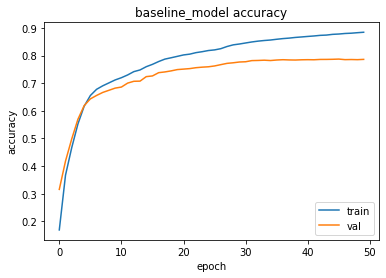

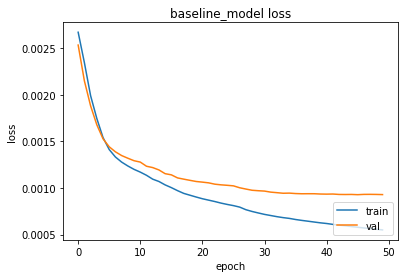

In [ ]:
plot_accuracy(baseline_training, 'baseline model')
plot_loss(baseline_training, 'baseline model')

## Other models
Experiment doing small modifications to the baseline model

### Gru model
Uses a GRU instead of the LSTM layer

#### Create GRU model

In [ ]:
def create_gru_model(units_gru, activation):
    gru_model = keras.Sequential()
    gru_model.add(layers.Embedding(input_dim = VOCABULARY_SIZE,
                                 output_dim    = embedding_dimension,
                                 input_length  = find_max_length(x_train),
                                 weights       = [embedding_matrix],
                                 trainable = False,
                                 mask_zero = True
                                ))
    gru_model.add(layers.Bidirectional(layers.GRU(units_gru, return_sequences=True)))
    #bidirect_model.add(layers.TimeDistributed(layers.Dense(len(tag_to_idx), activation='softmax')))
    gru_model.add(layers.Dense(TAG_VOCABULARY_SIZE, activation=activation))
    
    return gru_model

In [ ]:
gru_model = create_gru_model(64, ACTIVATION)
gru_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 186, 50)           526000    
                                                                 
 bidirectional_1 (Bidirectio  (None, 186, 128)         44544     
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 186, 40)           5160      
                                                                 
Total params: 575,704
Trainable params: 49,704
Non-trainable params: 526,000
_________________________________________________________________


#### Train gru model

In [ ]:
gru_model.compile(loss="mse",
              optimizer="Adam",
              metrics=['mae', "acc"])
gru_training = gru_model.fit(x=x_train, y=y_train, validation_data=(x_val, y_val), batch_size=BATCH_SIZE,  epochs=EPOCHS)

# Save the model when training is finished
save_model(gru_model, 'gru_model')

Epoch 1/50
59/59 [==============================] - 16s 150ms/step - loss: 0.0026 - mae: 0.0459 - acc: 0.2335 - val_loss: 0.0023 - val_mae: 0.0418 - val_acc: 0.3816
Epoch 2/50
59/59 [==============================] - 8s 130ms/step - loss: 0.0021 - mae: 0.0381 - acc: 0.4337 - val_loss: 0.0019 - val_mae: 0.0350 - val_acc: 0.4862
Epoch 3/50
59/59 [==============================] - 9s 145ms/step - loss: 0.0018 - mae: 0.0323 - acc: 0.5493 - val_loss: 0.0017 - val_mae: 0.0302 - val_acc: 0.5760
Epoch 4/50
59/59 [==============================] - 10s 176ms/step - loss: 0.0015 - mae: 0.0281 - acc: 0.6151 - val_loss: 0.0015 - val_mae: 0.0275 - val_acc: 0.6141
Epoch 5/50
59/59 [==============================] - 10s 163ms/step - loss: 0.0014 - mae: 0.0261 - acc: 0.6471 - val_loss: 0.0014 - val_mae: 0.0260 - val_acc: 0.6475
Epoch 6/50
59/59 [==============================] - 8s 131ms/step - loss: 0.0013 - mae: 0.0240 - acc: 0.6824 - val_loss: 0.0013 - val_mae: 0.0241 - val_acc: 0.6671
Epoch 7/50
59

INFO:tensorflow:Assets written to: models/model_gru_model_06_12_2021_11:32:18/assets


INFO:tensorflow:Assets written to: models/model_gru_model_06_12_2021_11:32:18/assets


Successfully saved


#### Plot results

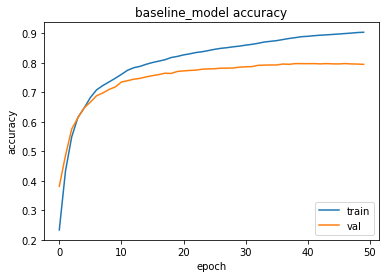

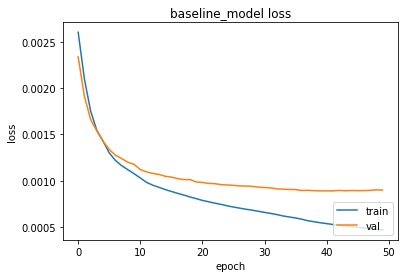

In [ ]:
plot_accuracy(gru_training, 'gru model')
plot_loss(gru_training, 'gru model')

### Two LSTM layers
Adding an additional LSTM layer to the baseline model.

#### Create model

In [ ]:
def create_doubleLSTM_model(units_LSTM1, units_LSTM2, activation):
    doubleLSTM_model = keras.Sequential()
    doubleLSTM_model.add(layers.Embedding(input_dim = VOCABULARY_SIZE,
                                 output_dim    = embedding_dimension,
                                 input_length  = find_max_length(x_train),
                                 weights       = [embedding_matrix],
                                 trainable     = False,
                                 mask_zero = True
                                ))
    doubleLSTM_model.add(layers.Bidirectional(layers.LSTM(units_LSTM1, return_sequences=True)))
    doubleLSTM_model.add(layers.Bidirectional(layers.LSTM(units_LSTM2, return_sequences=True)))
    #bidirect_model.add(layers.TimeDistributed(layers.Dense(len(tag_to_idx), activation='softmax')))
    doubleLSTM_model.add(layers.Dense(TAG_VOCABULARY_SIZE, activation=activation))
    
    return doubleLSTM_model

In [ ]:
doubleLSTM_model = create_doubleLSTM_model(64, 64, ACTIVATION)
doubleLSTM_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 186, 50)           526000    
                                                                 
 bidirectional_2 (Bidirectio  (None, 186, 128)         58880     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 186, 128)         98816     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 186, 40)           5160      
                                                                 
Total params: 688,856
Trainable params: 162,856
Non-trainable params: 526,000
_________________________________________________________________


#### Train model 

In [ ]:
doubleLSTM_model.compile(loss="mse",
              optimizer="Adam",
              metrics=['mae', "acc"])
doubleLSTM_training = doubleLSTM_model.fit(x=x_train, batch_size=BATCH_SIZE, y=y_train, epochs=EPOCHS, validation_data=(x_val, y_val))

# Save the model when training is finished
save_model(doubleLSTM_model, 'doubleLSTM_model')

Epoch 1/50
59/59 [==============================] - 36s 399ms/step - loss: 0.0027 - mae: 0.0470 - acc: 0.1584 - val_loss: 0.0026 - val_mae: 0.0454 - val_acc: 0.1915
Epoch 2/50
59/59 [==============================] - 19s 314ms/step - loss: 0.0025 - mae: 0.0444 - acc: 0.2459 - val_loss: 0.0025 - val_mae: 0.0436 - val_acc: 0.2872
Epoch 3/50
59/59 [==============================] - 19s 323ms/step - loss: 0.0023 - mae: 0.0406 - acc: 0.3600 - val_loss: 0.0021 - val_mae: 0.0376 - val_acc: 0.4383
Epoch 4/50
59/59 [==============================] - 18s 303ms/step - loss: 0.0019 - mae: 0.0344 - acc: 0.4832 - val_loss: 0.0018 - val_mae: 0.0328 - val_acc: 0.5267
Epoch 5/50
59/59 [==============================] - 20s 344ms/step - loss: 0.0016 - mae: 0.0302 - acc: 0.5813 - val_loss: 0.0016 - val_mae: 0.0286 - val_acc: 0.6033
Epoch 6/50
59/59 [==============================] - 21s 362ms/step - loss: 0.0014 - mae: 0.0264 - acc: 0.6402 - val_loss: 0.0014 - val_mae: 0.0261 - val_acc: 0.6345
Epoch 7/50

INFO:tensorflow:Assets written to: models/model_doubleLSTM_model_06_12_2021_11:49:21/assets


INFO:tensorflow:Assets written to: models/model_doubleLSTM_model_06_12_2021_11:49:21/assets


Successfully saved


#### Plot results

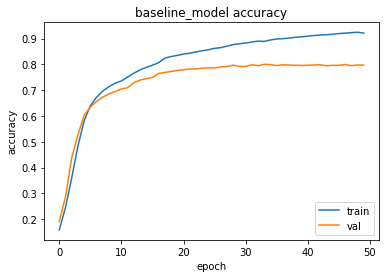

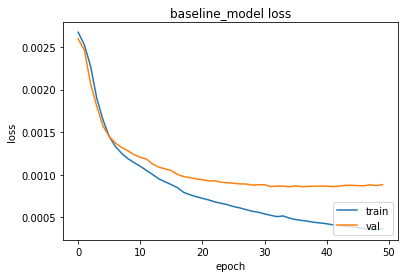

In [ ]:
plot_accuracy(doubleLSTM_training, 'double LSTM model')
plot_loss(doubleLSTM_training, 'double LSTM model')

### Two dense layers
Add an additional dense layer to the baseline model.

#### Create model

In [ ]:
def create_doubledense_model(units_LSTM, units_dense, activation):
    doubledense_model = keras.Sequential()
    doubledense_model.add(layers.Embedding(input_dim = VOCABULARY_SIZE,
                                 output_dim    = embedding_dimension,
                                 input_length  = find_max_length(x_train),
                                 weights       = [embedding_matrix],
                                 trainable = False, 
                                 mask_zero = True
                                ))
    doubledense_model.add(layers.Bidirectional(layers.LSTM(units_LSTM, return_sequences=True)))
    doubledense_model.add(layers.Dense(units_dense))
    #bidirect_model.add(layers.TimeDistributed(layers.Dense(len(tag_to_idx), activation='softmax')))
    doubledense_model.add(layers.Dense(TAG_VOCABULARY_SIZE, activation=activation))
    
    return doubledense_model

In [ ]:
doubleDense_model = create_doubledense_model(64, 64, ACTIVATION)
doubleDense_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 186, 50)           526000    
                                                                 
 bidirectional_4 (Bidirectio  (None, 186, 128)         58880     
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 186, 64)           8256      
                                                                 
 dense_4 (Dense)             (None, 186, 40)           2600      
                                                                 
Total params: 595,736
Trainable params: 69,736
Non-trainable params: 526,000
_________________________________________________________________


#### Train model

In [ ]:
doubleDense_model.compile(loss="mse",
              optimizer="Adam",
              metrics=['mae', "acc"])
doubleDense_training = doubleDense_model.fit(x=x_train, batch_size=BATCH_SIZE, y=y_train, epochs=EPOCHS, validation_data=(x_val, y_val))

# Save the model when training is finished
save_model(doubleDense_model, 'doubleDense_model')

Epoch 1/50
59/59 [==============================] - 21s 191ms/step - loss: 0.0026 - mae: 0.0463 - acc: 0.2068 - val_loss: 0.0024 - val_mae: 0.0433 - val_acc: 0.3318
Epoch 2/50
59/59 [==============================] - 9s 155ms/step - loss: 0.0022 - mae: 0.0392 - acc: 0.4004 - val_loss: 0.0020 - val_mae: 0.0357 - val_acc: 0.4663
Epoch 3/50
59/59 [==============================] - 9s 147ms/step - loss: 0.0018 - mae: 0.0323 - acc: 0.5313 - val_loss: 0.0017 - val_mae: 0.0301 - val_acc: 0.5677
Epoch 4/50
59/59 [==============================] - 9s 159ms/step - loss: 0.0015 - mae: 0.0274 - acc: 0.6179 - val_loss: 0.0015 - val_mae: 0.0266 - val_acc: 0.6219
Epoch 5/50
59/59 [==============================] - 8s 136ms/step - loss: 0.0014 - mae: 0.0246 - acc: 0.6607 - val_loss: 0.0014 - val_mae: 0.0244 - val_acc: 0.6539
Epoch 6/50
59/59 [==============================] - 9s 149ms/step - loss: 0.0013 - mae: 0.0226 - acc: 0.6954 - val_loss: 0.0013 - val_mae: 0.0229 - val_acc: 0.6810
Epoch 7/50
59/5

INFO:tensorflow:Assets written to: models/model_doubleDense_model_06_12_2021_11:57:39/assets


INFO:tensorflow:Assets written to: models/model_doubleDense_model_06_12_2021_11:57:39/assets


Successfully saved


#### Plot results

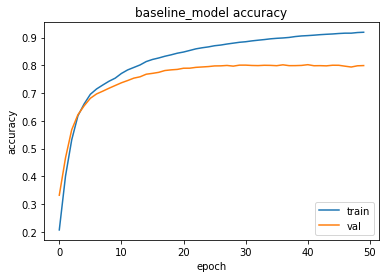

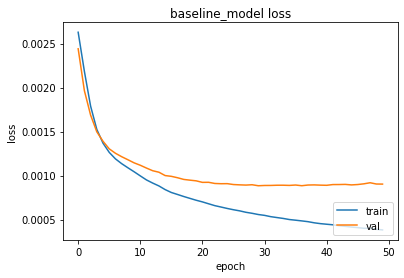

In [ ]:
plot_accuracy(doubleDense_training, 'double Dense model')
plot_loss(doubleDense_training , 'double Dense model')

## Evaluation of the two best models
The models with the best validation accuracy is the double dense layered model and the double LSTM layered model

### Double LSTM model

#### Load model

In [ ]:
doubleLSTM_model = keras.models.load_model('models/model_doubleLSTM_model_06_12_2021_11:49:21')

2021-12-07 13:34:43.352725: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2021-12-07 13:34:44.512803: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2021-12-07 13:34:44.528796: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2021-12-07 13:34:47.158121: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2021-12-07 13:34:47.173290: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_sh

#### Calculate predicitons for test set

In [ ]:
predictions_doubleLSTM = predict(doubleLSTM_model, x_test, {'batch_size': BATCH_SIZE})

#### Evaluate model
Evaluate how well the models predicitons for the test set where

ACCURACY: 0.792
PRECISION: 0.785
RECALL: 0.792
F1: 0.787
              precision    recall  f1-score   support

           1       0.75      0.77      0.76      2207
           2       0.74      0.83      0.78      1368
           3       0.87      0.86      0.86      1521
           4       0.94      0.90      0.92      1260
           5       0.77      0.77      0.77       886
           6       0.63      0.65      0.64       859
           7       0.79      0.81      0.80       600
           8       0.69      0.73      0.71       357
           9       0.81      0.86      0.83       791
          10       0.85      0.87      0.86       383
          11       0.91      0.84      0.88       334
          12       0.87      0.82      0.84       258
          13       0.67      0.54      0.60       331
          14       0.93      0.89      0.91       361
          15       0.95      0.92      0.94       181
          16       0.53      0.44      0.48       209
          17       0.81 

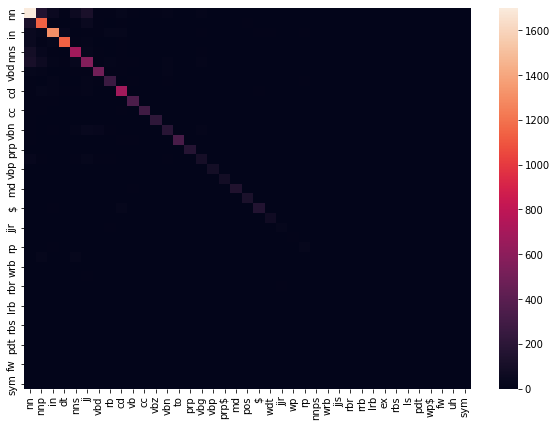

In [ ]:
evaluate(y_test, predictions_doubleLSTM, tag_tokenizer.index_word)

### Double dense model

#### Load model

In [ ]:
doubleDense_model = keras.models.load_model('models/model_doubleDense_model_06_12_2021_11:57:39')

2021-12-07 13:34:10.913255: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2021-12-07 13:34:11.019533: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2021-12-07 13:34:11.075631: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2021-12-07 13:34:11.651194: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2021-12-07 13:34:12.782891: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 14 outputs but the _ou

#### Calculate predicitons for test set

In [ ]:
predictions_doubleDense = predict(doubleDense_model, x_test, {'batch_size': BATCH_SIZE})

#### Evaluate model
Evaluate how well the models predicitons for the test set where

ACCURACY: 0.791
PRECISION: 0.788
RECALL: 0.791
F1: 0.789
              precision    recall  f1-score   support

           1       0.76      0.76      0.76      2207
           2       0.74      0.80      0.77      1368
           3       0.89      0.85      0.87      1521
           4       0.94      0.91      0.92      1260
           5       0.81      0.79      0.80       886
           6       0.62      0.64      0.63       859
           7       0.80      0.81      0.80       600
           8       0.63      0.77      0.69       357
           9       0.81      0.86      0.83       791
          10       0.81      0.87      0.84       383
          11       0.91      0.82      0.86       334
          12       0.83      0.84      0.84       258
          13       0.68      0.59      0.63       331
          14       0.94      0.90      0.92       361
          15       0.93      0.93      0.93       181
          16       0.47      0.39      0.43       209
          17       0.76 

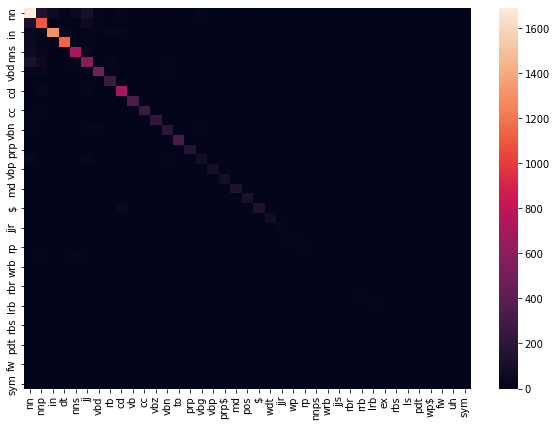

In [ ]:
evaluate(y_test, predictions_doubleDense, tag_tokenizer.index_word)